# Perovskites

In this notebook, we provide code to reproduce the results shown in our manuscript on the problem of predicting the volume of perovskites using only the chemical formula.

In [1]:
import functools
import pickle
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tpot
import sklearn
import optuna
import xgboost

import xenonpy.descriptor

import sys, os

sys.path.append("../../../")
from DigitalEcosystem.utils.figures import save_parity_plot_publication_quality
from DigitalEcosystem.utils.misc import root_mean_squared_error
import DigitalEcosystem
from IPython.display import Latex

pd.options.mode.chained_assignment = None 

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 42
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Plot Configuration
plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams["font.size"] = 32

In [4]:
from xenonpy.datatools import preset
preset.sync('elements')
preset.sync('elements_completed')

fetching dataset `elements` from https://github.com/yoshida-lab/dataset/releases/download/v0.1.3/elements.pd.xz.
fetching dataset `elements_completed` from https://github.com/yoshida-lab/dataset/releases/download/v0.1.3/elements_completed.pd.xz.


# Read in the Data

To start, we'll read in the data. Then, we'll scale the volume of the unit cell by the numberof formula units, such that it has units of Å^3 / formula unit.
Next, we'll use XenonPy to generate a set of compositional descriptors for the dataset, which are derived from only the chemical formula.

In [6]:
data = pd.read_pickle('../../raw_data/perovskites.pkl')

# Scale volume to have units of Å^3 / formula unit
data["Volume"] /= data["Atoms_Object"].apply(lambda atoms: len(atoms)//5)

# Featurize with XenonPy
cal = xenonpy.descriptor.Compositions()
data["Symbols"] = data.Atoms_Object.apply(lambda atoms: collections.Counter(atoms.get_chemical_symbols()))
test = cal.transform(data["Symbols"])
featurized_data = pd.concat([data, cal.transform(data.Symbols)], axis=1)

data = featurized_data.drop(columns=['Symbols'])
data

,Formula,Atoms_Object,Volume,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
0,AgCl3K,"(Atom('K', [2.546784180928994, 2.5467841809289...",132.452162,23.4,164.212290,215.4,22.340,50.663300,849.560,21.280000,...,1.0,3.0,0.237,0.00890,175.0,182.0,207.0,314.8,206.0,2.180
1,La2N6W2,"(Atom('La', [2.665318694121161, 2.857224133724...",65.894295,30.4,120.800000,214.8,16.786,72.953294,1978.440,102.018930,...,2.0,2.0,0.133,0.02583,155.0,166.0,193.0,309.6,333.6,1.100
2,O3SrV,"(Atom('Sr', [1.9322684339857643, 1.93226843398...",57.715487,17.0,157.520852,208.8,16.810,37.311700,1115.514,92.159719,...,2.0,2.0,0.301,0.02658,152.0,150.0,182.0,314.4,317.5,0.802
3,Cl6Cs2Tl2,"(Atom('Cs', [7.926562986915786, 0.0, 0.0289390...",176.625755,37.4,176.012290,221.8,28.660,88.727090,679.480,9.580000,...,1.0,3.0,0.128,0.00890,175.0,182.0,207.0,394.7,206.0,2.180
4,F3MnRb,"(Atom('Rb', [2.1409860345006186, 2.14098603450...",78.511177,17.8,157.014169,194.2,22.918,39.480211,690.206,52.579364,...,1.0,2.0,0.360,0.02770,147.0,146.0,171.0,296.1,1300.0,0.557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,F6In2Mn2,"(Atom('In', [3.004706503626541, 3.051648750812...",77.734000,20.2,140.614169,195.4,14.878,45.350251,968.606,67.917949,...,2.0,2.0,0.234,0.02770,147.0,146.0,171.0,296.1,1215.0,0.557
140,CaF3Rb,"(Atom('Rb', [2.259732663194181, 2.259732663194...",92.312641,16.8,169.414169,199.8,27.420,36.508202,594.606,31.979364,...,1.0,2.0,0.360,0.02770,147.0,146.0,171.0,336.4,1300.0,0.557
141,MoNaO3,"(Atom('Na', [0.0, 0.0, 0.0], index=0), Atom('M...",59.086370,15.4,153.520852,196.4,15.020,33.387354,1262.334,92.923625,...,1.0,2.0,0.251,0.02658,152.0,150.0,182.0,298.3,317.5,0.802
142,KO3W,"(Atom('K', [0.0, 0.0, 0.0], index=0), Atom('W'...",62.178694,23.4,162.920852,200.0,19.366,54.187060,1449.514,108.283625,...,1.0,2.0,0.133,0.02658,152.0,150.0,182.0,309.6,317.5,0.802


# Prepare Data

Next up, we'll set "volume" as the target column, and extract out the xenonpy descriptors from the dataset.
Then we'll perform a train/test split, holding out 10% of the data as a test set.

In [7]:
target_column = ['Volume']
xenonpy_descriptors = [col for col in data.columns if ":" in col]

descriptors = xenonpy_descriptors

train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)

train_x = train[descriptors].to_numpy()
train_y = train[target_column].to_numpy()

test_x = test[descriptors].to_numpy()
test_y = test[target_column].to_numpy()

In [8]:
metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': root_mean_squared_error,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

In [9]:
print("[")
for desc in descriptors:
    print(f"    \"{desc}\",")
print("]")

data.to_csv("perovskite_data.csv", index_label="ID")

[
    "ave:atomic_number",
    "ave:atomic_radius",
    "ave:atomic_radius_rahm",
    "ave:atomic_volume",
    "ave:atomic_weight",
    "ave:boiling_point",
    "ave:bulk_modulus",
    "ave:c6_gb",
    "ave:covalent_radius_cordero",
    "ave:covalent_radius_pyykko",
    "ave:covalent_radius_pyykko_double",
    "ave:covalent_radius_pyykko_triple",
    "ave:covalent_radius_slater",
    "ave:density",
    "ave:dipole_polarizability",
    "ave:electron_negativity",
    "ave:electron_affinity",
    "ave:en_allen",
    "ave:en_ghosh",
    "ave:en_pauling",
    "ave:first_ion_en",
    "ave:fusion_enthalpy",
    "ave:gs_bandgap",
    "ave:gs_energy",
    "ave:gs_est_bcc_latcnt",
    "ave:gs_est_fcc_latcnt",
    "ave:gs_mag_moment",
    "ave:gs_volume_per",
    "ave:hhi_p",
    "ave:hhi_r",
    "ave:heat_capacity_mass",
    "ave:heat_capacity_molar",
    "ave:icsd_volume",
    "ave:evaporation_heat",
    "ave:heat_of_formation",
    "ave:lattice_constant",
    "ave:mendeleev_number",
    "ave:m

# XGBoost

XGBoost is a gradient boosting algorithm that uses an ensemble of decision trees. It's a very flexible model that comes with a lot of hyperparameters to tune. To tune them, we'll use Optuna, a Bayesian optimization framework. We'll also use Optuna to choose whether we use Z-score normalization or min/max scaling on the data.

We'll hold out 20% of the data as a validation set, for early-stopping and pruning purposes. We'll train the model to minimize its RMSE on the training set.

In [ ]:
current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x), train_y, test_size=0.2, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_reg


    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 2),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 2),
        'max_depth': trial.suggest_int('max_depth', 1, 256),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2)
    }
    
    scalers = {
        "StandardScaler": sklearn.preprocessing.StandardScaler(),
        "MinMaxScaler": sklearn.preprocessing.MinMaxScaler()
    }

    scaler = trial.suggest_categorical('scaler', scalers.keys())

    current_reg = sklearn.pipeline.Pipeline([
        (scaler, scalers[scaler]),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(**params,
                                               n_estimators=256,
                                               n_jobs=1,
                                               objective='reg:squarederror',
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 50,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    mse = sklearn.metrics.mean_squared_error(
        y_true=objective_validation_y_reg,
        y_pred=current_reg.predict(objective_validation_x_reg),
    )
    rmse = np.sqrt(mse)

    return rmse

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=256),
    direction='minimize')

reg_study.optimize(func=objective, n_trials=1000, callbacks=[keep_best_reg])

In [ ]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = train_y,
                                                                    train_y_pred = best_reg.predict(train_x),
                                                                    test_y_true = test_y,
                                                                    test_y_pred = best_reg.predict(test_x),
                                                                    axis_label = "Perovskite Volume (Å^3 / formula unit)",
                                                                    filename = "xgboost_perovskite_volume_parity.jpeg")

In [ ]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=best_reg.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=best_reg.predict(train_x))
    print(key,np.round(value,4))

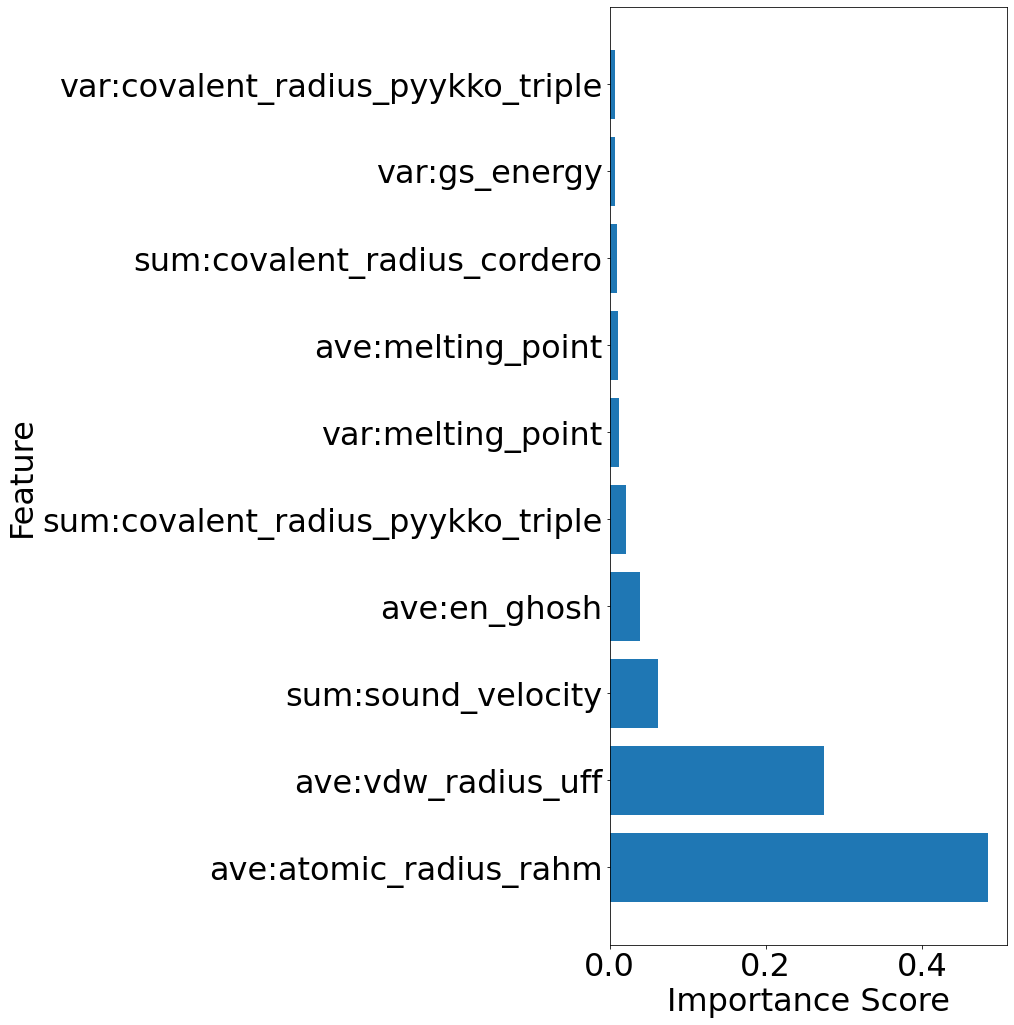

In [109]:
n_importances = 10
importances = list(zip(best_reg[1].feature_importances_, xenonpy_descriptors))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))

plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("xgboost_perovskite_volume_importances.jpeg")

Finally, for some book-keeping purposes, we'll go ahead and save the predictions from the XGBoost model, along with the importance scores from the above plot. Also, we'll go ahead and pickle the XGBoost pipeline.

In [74]:
train_preds = train[target_column]
train_preds['TrainTest Status'] = ['Training Set'] * len(train_preds)
train_preds['Prediction'] = best_reg.predict(train_x)

test_preds = test[target_column]
test_preds['TrainTest Status'] = ['Test Set'] * len(test_preds)
test_preds['Prediction'] = best_reg.predict(test_x)

xgb_predictions = train_preds.append(test_preds)
xgb_predictions.to_csv("xgboost_perovskite_volume_predictions.csv")

In [93]:
with open("xgboost_perovskite_volume_importances.csv", "w") as outp:
    outp.write("Descriptor,XGB_Importance\n")
    for importance, descriptor in sorted_importances:
        outp.write(f"{descriptor},{importance}\n")

In [110]:
with open("xgboost_pipeline.pkl", "wb") as outp:
    pickle.dump(best_reg, outp)

# TPOT

TPOT is an AutoML solution that uses a genetic algorithm to create an ML pipeline to address a given problem.
Here, we'll run a population of 100 models over 10 generations, taking the 10-fold cross-validated RMSE as the fitness metric.

We'll also go ahead and save a parity plot of the TPOT model.

In [ ]:
tpot_model = tpot.TPOTRegressor(
    generations=100,
    population_size=100,
    cv=10,
    verbosity=2,
    scoring="neg_root_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

tpot_model.fit(train_x, train_y.ravel())

DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = train_y,
                                                                    train_y_pred = tpot_model.predict(train_x),
                                                                    test_y_true = test_y,
                                                                    test_y_pred = tpot_model.predict(test_x),
                                                                    axis_label = "Perovskite Volume (Å^3 / formula unit)",
                                                                    filename = "tpot_perovskite_volume_parity.jpeg")

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -5.281849421733427

Generation 2 - Current best internal CV score: -5.281849421733427

Generation 3 - Current best internal CV score: -4.658250012018058

Generation 4 - Current best internal CV score: -4.658250012018058

Generation 5 - Current best internal CV score: -4.658250012018058

Generation 6 - Current best internal CV score: -4.656331047823466

Generation 7 - Current best internal CV score: -4.649496805631231

Generation 8 - Current best internal CV score: -4.474949708728163

Generation 9 - Current best internal CV score: -4.474949708728163

Generation 10 - Current best internal CV score: -4.474949708728163

Generation 11 - Current best internal CV score: -4.474949708728163

Generation 12 - Current best internal CV score: -4.474949708728163

Generation 13 - Current best internal CV score: -4.474949708728163

Generation 14 - Current best internal CV score: -4.474949708728163

Generation 15 - Current best internal CV score: -4.43614

In [ ]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = train_y,
                                                                    train_y_pred = tpot_model.predict(train_x),
                                                                    test_y_true = test_y,
                                                                    test_y_pred = tpot_model.predict(test_x),
                                                                    axis_label = "Perovskite Volume (Å^3 / formula unit)",
                                                                    filename = "tpot_perovskite_volume_parity.jpeg")

In [ ]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=tpot_model.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=tpot_model.predict(train_x))
    print(key,np.round(value,4))

Finally, we'll go ahead and back up those predictions to the disk (this way, we don't need to re-run this again just to get those).

In [ ]:
train_preds = train[target_column]
train_preds['TrainTest Status'] = ['Training Set'] * len(train_preds)
train_preds['Prediction'] = tpot_model.predict(train_x)

test_preds = test[target_column]
test_preds['TrainTest Status'] = ['Test Set'] * len(test_preds)
test_preds['Prediction'] = tpot_model.predict(test_x)

tpot_predictions = train_preds.append(test_preds)
tpot_predictions.to_csv("tpot_perovskite_volume_predictions.csv")

We'll also have TPOT automatically generate some Python code to recreate its model. This will get saved to a file named "tpot_autogenerated_pipeline.py." More detail on what this does can be found on TPOT's documentation here: [Link](http://epistasislab.github.io/tpot/using/).

As another mechanism of saving the model, we'll also pickle it.

In [ ]:
tpot_model.export('tpot_autogenerated_pipeline.py')

with open("tpot_pipeline.pkl", "wb") as outp:
    pickle.dump(tpot_model.fitted_pipeline_, outp)

In [9]:
import numpy as np

generations = np.loadtxt("tpot/generations.dat")

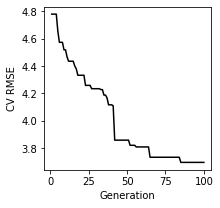

In [11]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["font.size"] = 10

plt.plot(generations[:, 0], -1*generations[:, 1], 'k-', lw=1.50)

plt.xlabel(f"Generation")
plt.ylabel(f"CV RMSE")
plt.savefig("perovskite_convergence.pdf")
plt.show()
plt.close()

# Roost

[Roost](https://github.com/CompRhys/roost) is a neural network approach to predicting material properties as a function of their composition. Although we only have 144 data-points here, we can at least try for a good model.

Since the model only requires material IDs, the composition, and the property of interest, we'll save a CSV containing those properties.

In [14]:
roost_dir = "./roost"
os.makedirs(roost_dir, exist_ok=True)

roost_data_train = train[['Formula', 'Volume']]
roost_data_test = test[['Formula', 'Volume']]

roost_data_train.to_csv(os.path.join(roost_dir, 'roost_train.csv'), index_label='material_id')
roost_data_test.to_csv(os.path.join(roost_dir, 'roost_test.csv'), index_label='material_id')

At this point, Roost models were run. Logs can be found in the Roost directory, along with the resultant predictions.

In [15]:
roost_train_results = pd.read_csv("roost/roost_train_predictions.csv", index_col="material_id")
roost_test_results  = pd.read_csv("roost/roost_test_predictions.csv", index_col="material_id")

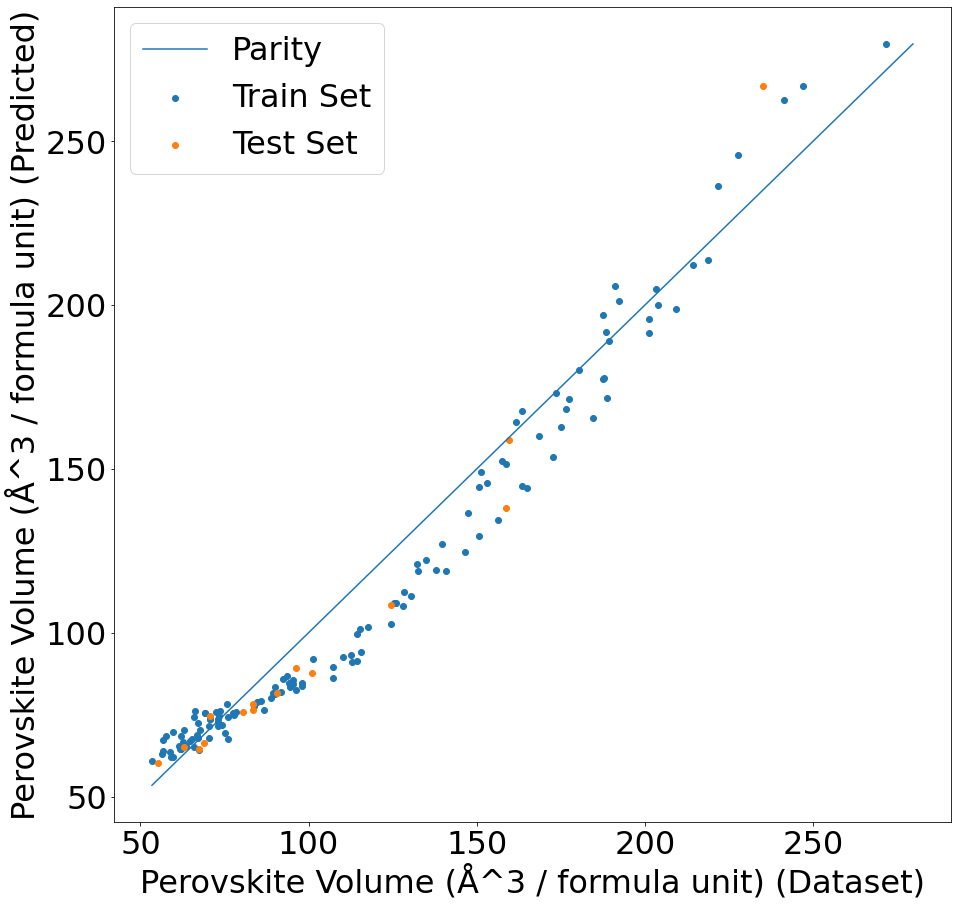

In [16]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = roost_train_results['volume_target'],
                                                                    train_y_pred =  roost_train_results['volume_pred_n0'],
                                                                    test_y_true = roost_test_results['volume_target'],
                                                                    test_y_pred = roost_test_results['volume_pred_n0'],
                                                                    axis_label = "Perovskite Volume (Å^3 / formula unit)",
                                                                    filename = "roost_perovskite_volume_parity.jpeg")

In [17]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_test_results['volume_target'], y_pred=roost_test_results['volume_pred_n0'])
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_train_results['volume_target'], y_pred=roost_train_results['volume_pred_n0'])
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 31.686
MAE 8.8345
MSE 144.0499
RMSE 12.0021
MAPE 0.0782
R2 0.9347

Training Set Error Metrics
MaxError 22.936
MAE 9.1073
MSE 125.723
RMSE 11.2126
MAPE 0.0804
R2 0.955


# SISSO

SISSO is a symbolic regression technique focused on creating interpretable machine learning models. 

Due to the exponential computational cost of running a SISSO model as the number of features and rungs increases, we need to restrict the feature space. To do that, we'll use LASSO-based feature selection (essentially we can look at how quickly LASSO extinguishes a variable to get an idea of its importance). 

# SISSO++ ALL

In [10]:
from sissopp.py_interface import read_csv
from sissopp import FeatureSpace, SISSORegressor

from sissopp.postprocess.feature_space_analysis import get_prevelance_of_primary_features
from sissopp.postprocess.load_models import create_model_csv, load_model

from time import time
from pathlib import Path
import os

In [11]:
cwd = Path.cwd()

In [12]:
# Rename columns to include units
new_col_names = list(train.columns[:2]) + ["Volume (AA^3)", "ave:atomic_number", "ave:atomic_radius (pm)", "ave:atomic_radius_rahm (pm)", "ave:atomic_volume (cm^3 / mol)", "ave:atomic_weight (Da)", "ave:boiling_point (K)", "ave:bulk_modulus (GPa)", "ave:c6_gb (Eh / a0^6)", "ave:covalent_radius_cordero (pm)", "ave:covalent_radius_pyykko (pm)", "ave:covalent_radius_pyykko_double (pm)", "ave:covalent_radius_pyykko_triple (pm)", "ave:covalent_radius_slater (pm)", "ave:density (g / cm^3)", "ave:dipole_polarizability (AA_polar^3)", "ave:electron_negativity (Pauling)", "ave:electron_affinity (eV)", "ave:en_allen (eV)", "ave:en_ghosh (ghosh)", "ave:en_pauling (Pauling)", "ave:first_ion_en (eV)", "ave:fusion_enthalpy (KJ / mol)", "ave:gs_bandgap (eV)", "ave:gs_energy (eV)", "ave:gs_est_bcc_latcnt (AA)", "ave:gs_est_fcc_latcnt (AA)", "ave:gs_mag_moment (mu_B)", "ave:gs_volume_per (cm^3 / mol)", "ave:hhi_p", "ave:hhi_r", "ave:heat_capacity_mass (J / g / K)", "ave:heat_capacity_molar (J / mol / K)", "ave:icsd_volume (cm^3 / mol)", "ave:evaporation_heat (KJ / mol)", "ave:heat_of_formation (KJ / mol)", "ave:lattice_constant (AA)", "ave:mendeleev_number", "ave:melting_point (K)", "ave:molar_volume (cm^3)", "ave:num_unfilled", "ave:num_valance", "ave:num_d_unfilled", "ave:num_d_valence", "ave:num_f_unfilled", "ave:num_f_valence", "ave:num_p_unfilled", "ave:num_p_valence", "ave:num_s_unfilled", "ave:num_s_valence", "ave:period", "ave:specific_heat (J / g / K)", "ave:thermal_conductivity (W / m / K)", "ave:vdw_radius (pm)", "ave:vdw_radius_alvarez (pm)", "ave:vdw_radius_mm3 (pm)", "ave:vdw_radius_uff (pm)", "ave:sound_velocity (m / s)", "ave:Polarizability (AA_polar)", "sum:atomic_number", "sum:atomic_radius (pm)", "sum:atomic_radius_rahm (pm)", "sum:atomic_volume (cm^3 / mol)", "sum:atomic_weight (Da)", "sum:boiling_point (K)", "sum:bulk_modulus (GPa)", "sum:c6_gb (Eh / a0^6)", "sum:covalent_radius_cordero (pm)", "sum:covalent_radius_pyykko (pm)", "sum:covalent_radius_pyykko_double (pm)", "sum:covalent_radius_pyykko_triple (pm)", "sum:covalent_radius_slater (pm)", "sum:density (g / cm^3)", "sum:dipole_polarizability (AA_polar^3)", "sum:electron_negativity (Pauling)", "sum:electron_affinity (eV)", "sum:en_allen (eV)", "sum:en_ghosh (ghosh)", "sum:en_pauling (Pauling)", "sum:first_ion_en (eV)", "sum:fusion_enthalpy (KJ / mol)", "sum:gs_bandgap (eV)", "sum:gs_energy (eV)", "sum:gs_est_bcc_latcnt (AA)", "sum:gs_est_fcc_latcnt (AA)", "sum:gs_mag_moment (mu_B)", "sum:gs_volume_per (cm^3 / mol)", "sum:hhi_p", "sum:hhi_r", "sum:heat_capacity_mass (J / g / K)", "sum:heat_capacity_molar (J / mol / K)", "sum:icsd_volume (cm^3 / mol)", "sum:evaporation_heat (KJ / mol)", "sum:heat_of_formation (KJ / mol)", "sum:lattice_constant (AA)", "sum:mendeleev_number", "sum:melting_point (K)", "sum:molar_volume (cm^3)", "sum:num_unfilled", "sum:num_valance", "sum:num_d_unfilled", "sum:num_d_valence", "sum:num_f_unfilled", "sum:num_f_valence", "sum:num_p_unfilled", "sum:num_p_valence", "sum:num_s_unfilled", "sum:num_s_valence", "sum:period", "sum:specific_heat (J / g / K)", "sum:thermal_conductivity (W / m / K)", "sum:vdw_radius (pm)", "sum:vdw_radius_alvarez (pm)", "sum:vdw_radius_mm3 (pm)", "sum:vdw_radius_uff (pm)", "sum:sound_velocity (m / s)", "sum:Polarizability (AA_polar)", "var:atomic_number", "var:atomic_radius (pm)", "var:atomic_radius_rahm (pm)", "var:atomic_volume (cm^3 / mol)", "var:atomic_weight (Da)", "var:boiling_point (K)", "var:bulk_modulus (GPa)", "var:c6_gb (Eh / a0^6)", "var:covalent_radius_cordero (pm)", "var:covalent_radius_pyykko (pm)", "var:covalent_radius_pyykko_double (pm)", "var:covalent_radius_pyykko_triple (pm)", "var:covalent_radius_slater (pm)", "var:density (g / cm^3)", "var:dipole_polarizability (AA_polar^3)", "var:electron_negativity (Pauling)", "var:electron_affinity (eV)", "var:en_allen (eV)", "var:en_ghosh (ghosh)", "var:en_pauling (Pauling)", "var:first_ion_en (eV)", "var:fusion_enthalpy (KJ / mol)", "var:gs_bandgap (eV)", "var:gs_energy (eV)", "var:gs_est_bcc_latcnt (AA)", "var:gs_est_fcc_latcnt (AA)", "var:gs_mag_moment (mu_B)", "var:gs_volume_per (cm^3 / mol)", "var:hhi_p", "var:hhi_r", "var:heat_capacity_mass (J / g / K)", "var:heat_capacity_molar (J / mol / K)", "var:icsd_volume (cm^3 / mol)", "var:evaporation_heat (KJ / mol)", "var:heat_of_formation (KJ / mol)", "var:lattice_constant (AA)", "var:mendeleev_number", "var:melting_point (K)", "var:molar_volume (cm^3)", "var:num_unfilled", "var:num_valance", "var:num_d_unfilled", "var:num_d_valence", "var:num_f_unfilled", "var:num_f_valence", "var:num_p_unfilled", "var:num_p_valence", "var:num_s_unfilled", "var:num_s_valence", "var:period", "var:specific_heat (J / g / K)", "var:thermal_conductivity (W / m / K)", "var:vdw_radius (pm)", "var:vdw_radius_alvarez (pm)", "var:vdw_radius_mm3 (pm)", "var:vdw_radius_uff (pm)", "var:sound_velocity (m / s)", "var:Polarizability (AA_polar)", "max:atomic_number", "max:atomic_radius (pm)", "max:atomic_radius_rahm (pm)", "max:atomic_volume (cm^3 / mol)", "max:atomic_weight (Da)", "max:boiling_point (K)", "max:bulk_modulus (GPa)", "max:c6_gb (Eh / a0^6)", "max:covalent_radius_cordero (pm)", "max:covalent_radius_pyykko (pm)", "max:covalent_radius_pyykko_double (pm)", "max:covalent_radius_pyykko_triple (pm)", "max:covalent_radius_slater (pm)", "max:density (g / cm^3)", "max:dipole_polarizability (AA_polar^3)", "max:electron_negativity (Pauling)", "max:electron_affinity (eV)", "max:en_allen (eV)", "max:en_ghosh (ghosh)", "max:en_pauling (Pauling)", "max:first_ion_en (eV)", "max:fusion_enthalpy (KJ / mol)", "max:gs_bandgap (eV)", "max:gs_energy (eV)", "max:gs_est_bcc_latcnt (AA)", "max:gs_est_fcc_latcnt (AA)", "max:gs_mag_moment (mu_B)", "max:gs_volume_per (cm^3 / mol)", "max:hhi_p", "max:hhi_r", "max:heat_capacity_mass (J / g / K)", "max:heat_capacity_molar (J / mol / K)", "max:icsd_volume (cm^3 / mol)", "max:evaporation_heat (KJ / mol)", "max:heat_of_formation (KJ / mol)", "max:lattice_constant (AA)", "max:mendeleev_number", "max:melting_point (K)", "max:molar_volume (cm^3)", "max:num_unfilled", "max:num_valance", "max:num_d_unfilled", "max:num_d_valence", "max:num_f_unfilled", "max:num_f_valence", "max:num_p_unfilled", "max:num_p_valence", "max:num_s_unfilled", "max:num_s_valence", "max:period", "max:specific_heat (J / g / K)", "max:thermal_conductivity (W / m / K)", "max:vdw_radius (pm)", "max:vdw_radius_alvarez (pm)", "max:vdw_radius_mm3 (pm)", "max:vdw_radius_uff (pm)", "max:sound_velocity (m / s)", "max:Polarizability (AA_polar)", "min:atomic_number", "min:atomic_radius (pm)", "min:atomic_radius_rahm (pm)", "min:atomic_volume (cm^3 / mol)", "min:atomic_weight (Da)", "min:boiling_point (K)", "min:bulk_modulus (GPa)", "min:c6_gb (Eh / a0^6)", "min:covalent_radius_cordero (pm)", "min:covalent_radius_pyykko (pm)", "min:covalent_radius_pyykko_double (pm)", "min:covalent_radius_pyykko_triple (pm)", "min:covalent_radius_slater (pm)", "min:density (g / cm^3)", "min:dipole_polarizability (AA_polar^3)", "min:electron_negativity (Pauling)", "min:electron_affinity (eV)", "min:en_allen (eV)", "min:en_ghosh (ghosh)", "min:en_pauling (Pauling)", "min:first_ion_en (eV)", "min:fusion_enthalpy (KJ / mol)", "min:gs_bandgap (eV)", "min:gs_energy (eV)", "min:gs_est_bcc_latcnt (AA)", "min:gs_est_fcc_latcnt (AA)", "min:gs_mag_moment (mu_B)", "min:gs_volume_per (cm^3 / mol)", "min:hhi_p", "min:hhi_r", "min:heat_capacity_mass (J / g / K)", "min:heat_capacity_molar (J / mol / K)", "min:icsd_volume (cm^3 / mol)", "min:evaporation_heat (KJ / mol)", "min:heat_of_formation (KJ / mol)", "min:lattice_constant (AA)", "min:mendeleev_number", "min:melting_point (K)", "min:molar_volume (cm^3)", "min:num_unfilled", "min:num_valance", "min:num_d_unfilled", "min:num_d_valence", "min:num_f_unfilled", "min:num_f_valence", "min:num_p_unfilled", "min:num_p_valence", "min:num_s_unfilled", "min:num_s_valence", "min:period", "min:specific_heat (J / g / K)", "min:thermal_conductivity (W / m / K)", "min:vdw_radius (pm)", "min:vdw_radius_alvarez (pm)", "min:vdw_radius_mm3 (pm)", "min:vdw_radius_uff (pm)", "min:sound_velocity (m / s)", "min:Polarizability (AA_polar)"]
col_remap = {}
for col, new_col in zip(train.columns, new_col_names):
    col_remap[col] = new_col

train_sisso = train.rename(columns=col_remap)
test_sisso = test.rename(columns=col_remap)

train_sisso.drop(["Formula", "Atoms_Object"], axis=1, inplace=True)
test_sisso.drop(["Formula", "Atoms_Object"], axis=1, inplace=True)


In [13]:
def gen_fs_sr(max_rung=2, n_sis=1000, leave_out_inds=[], n_dim=1, n_res=10, cols="all"):
    inputs = read_csv(train_sisso, "Volume", leave_out_inds=list(leave_out_inds), max_rung=max_rung, cols=cols)
    inputs.n_sis_select = n_sis
    inputs.allowed_ops = [
        "add",
        "sub",
        "mult",
        "div",
        "abs_diff",
        "inv",
        "abs",
        "cos",
        "sin",
        "exp",
        "neg_exp",
        "log",
        "sq",
        "sqrt",
        "cb",
        "cbrt",
        "six_pow",
    ]
    inputs.n_dim = n_dim
    inputs.n_residual = n_res
    fs = FeatureSpace(inputs)
    sr = SISSORegressor(inputs, fs)
    return fs, sr

In [14]:
r1_path = Path("sisso_update/rung_1_prev_check/")
r1_path.mkdir(parents=True, exist_ok=True)
os.chdir(r1_path)

fs_init, sr_init = gen_fs_sr(max_rung=1, n_sis=10000)
fs_init.sis(sr_init.prop_train)
phi_0_in_phi_sel = get_prevelance_of_primary_features(fs_init.phi_selected, fs_init.phi0)
prevelance = sorted([(key, val) for key, val in phi_0_in_phi_sel.items()], key=lambda prev: prev[1] * -1)

os.chdir(cwd)

Time to generate feat space: 1.04933 s
Projection time: 0.0352659 s
Time to get best features on rank : 0.0442669 s
Complete final combination/selection from all ranks: 0.0693851 s


In [15]:
cols = [prev[0] for prev in prevelance[:30]]
model_lists_1 = []
model_lists_2 = []
inds = np.arange(len(train_sisso.index))
np.random.shuffle(inds)
inds = [int(ind) for ind in inds]
k = 5
print(Path.cwd())
for ii in range(k):
    path_r1 = Path(f"sisso_update/rung_1/cv_{ii}")
    path_r1.mkdir(exist_ok=True, parents=True)
    if (path_r1 / "models/").exists():
        train_files = [[f"{path_r1}/models/train_dim_{dd}_model_{ii}.dat" for ii in range(1)] for dd in range(1, 3)]
        test_files = [[f"{path_r1}/models/test_dim_{dd}_model_{ii}.dat" for ii in range(1)] for dd in range(1, 3)]
        model_lists_1.append(
            [
                [load_model(tr_f, ts_f) for tr_f, ts_f in zip(train, test)] 
                for train, test in zip(train_files, test_files)
            ]
        )
    else:
        os.chdir(path_r1)
        t0 = time()
        fs_1, sr_1 = gen_fs_sr(max_rung=1, n_sis=500, cols="all", n_dim=2, leave_out_inds=inds[ii::k])
        sr_1.fit()
        model_lists_1.append(sr_1.models)
        os.chdir(cwd)
    
    path_r2 = Path(f"sisso_update/rung_2/cv_{ii}")
    path_r2.mkdir(exist_ok=True, parents=True)
    if (path_r2 / "models/").exists():
        train_files = [[f"{path_r2}/models/train_dim_{dd}_model_{ii}.dat" for ii in range(1)] for dd in range(1, 3)]
        test_files = [[f"{path_r2}/models/test_dim_{dd}_model_{ii}.dat" for ii in range(1)] for dd in range(1, 3)]
        model_lists_2.append(
            [
                [load_model(tr_f, ts_f) for tr_f, ts_f in zip(train, test)] 
                for train, test in zip(train_files, test_files)
            ]
        )
    else:
        os.chdir(path_r2)
        t0 = time()
        fs_2, sr_2 = gen_fs_sr(max_rung=2, n_sis=500, cols="all", n_dim=2, leave_out_inds=inds[ii::k])
        sr_2.fit()
        model_lists_2.append(sr_2.models)
        os.chdir(cwd)

/home/purcell/git/Scientific-Projects/DigitalEcosystem/publication/perovskiteVolume


In [16]:
for col in cols:
    print(col)

min:c6_gb
min:melting_point
min:Polarizability
min:atomic_number
min:fusion_enthalpy
min:dipole_polarizability
min:boiling_point
min:gs_volume_per
min:covalent_radius_pyykko_triple
var:covalent_radius_pyykko_triple
min:covalent_radius_slater
min:covalent_radius_pyykko_double
min:period
min:covalent_radius_pyykko
min:covalent_radius_cordero
min:atomic_weight
min:hhi_p
max:en_allen
ave:covalent_radius_pyykko_triple
min:atomic_radius_rahm
ave:atomic_number
ave:covalent_radius_slater
ave:gs_volume_per
ave:heat_capacity_mass
max:mendeleev_number
ave:covalent_radius_pyykko
min:vdw_radius_alvarez
min:vdw_radius_mm3
max:en_ghosh
min:vdw_radius


In [17]:
test_rmse = np.array([[models[dim][0].test_rmse for dim in range(2)] for models in model_lists_1])
print(test_rmse.mean(axis=0))
print(test_rmse.std(axis=0))

test_rmse = np.array([[models[dim][0].test_rmse for dim in range(2)] for models in model_lists_2])
print(test_rmse.mean(axis=0))
print(test_rmse.std(axis=0))

[17.07580592 10.82477769]
[2.00542893 1.40366853]
[13.75979755  9.66727954]
[1.95016693 1.00274814]


In [18]:
path_train = Path("sisso_update/train_final/")
path_train.mkdir(exist_ok=True, parents=True)
min_cv = test_rmse.mean(axis=0).argmin()
if (path_train / "models").exists():
    model = load_model(str(path_train / f"models/train_dim_{min_cv + 1}_model_0.dat"))
else:
    os.chdir(path_train)
    fs_fin, sr_fin = gen_fs_sr(max_rung=2, n_sis=500, cols=cols, n_dim=3)
    sr_fin.fit()
    os.chdir(cwd)
    model = sr_fin.models[test_rmse.mean(axis=0).argmin()][0]
    
model_df = create_model_csv(test_sisso, model)

In [19]:
data_dct = {}
for col in model_df.columns:
    data_dct[col] = model_df[col]

p_est = model.eval_many(data_dct)

In [20]:
print(model)
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=model.prop_train, y_pred=model.fit)
    print(key,np.round(value,4))
    
    
print("\nTest Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_sisso['Volume (AA^3)'], y_pred=p_est)
    print(key,np.round(value,4))

c0 + a0 * ((ave:atomic_number / ave:heat_capacity_mass) / (ave:covalent_radius_slater - ave:covalent_radius_pyykko_triple)) + a1 * ((ave:covalent_radius_pyykko_triple / ave:covalent_radius_pyykko) * (ave:gs_volume_per + min:gs_volume_per))

Training Set Error Metrics
MaxError 26.7373
MAE 7.2799
MSE 82.3567
RMSE 9.0751
MAPE 0.0744
R2 0.9705

Test Set Error Metrics
MaxError 10.2742
MAE 4.0502
MSE 22.1813
RMSE 4.7097
MAPE 0.0478
R2 0.9899


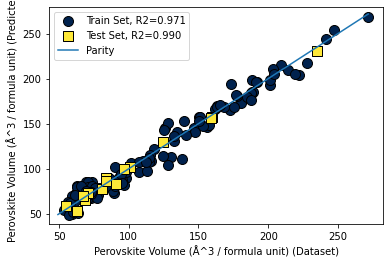

In [21]:
save_parity_plot_publication_quality(
    train_y_true = model.prop_train,
    train_y_pred =  model.fit,
    test_y_true = test_sisso['Volume (AA^3)'],
    test_y_pred = p_est,
    axis_label = "Perovskite Volume (Å^3 / formula unit)",
    filename = "sisso_perovskite_volume_parity.jpeg"
)

# Original SISSO LASO Selection Results

In [29]:
sisso_feature_selector = sklearn.feature_selection.SelectFromModel(sklearn.linear_model.LassoCV(random_state=RANDOM_SEED),
                                                                   threshold=-np.inf,
                                                                   max_features=16,
                                                                   prefit=False)
sisso_feature_selector.fit(train_x, train_y.ravel())

sisso_features = [col for (col, is_selected) in zip(train[descriptors].columns, sisso_feature_selector.get_support()) if is_selected]

Next, we'll save the training set. SISSO does its own internal test-set holdout, but we'll also save the test set that we created above, just so there's a record of that.

In [76]:
sisso_dir = "./sisso"
os.makedirs(sisso_dir, exist_ok=True)

sisso_data_train = train[target_column + sisso_features]
sisso_data_test = test[target_column + sisso_features]

sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_train.csv'), index_label='material_id')
sisso_data_test.to_csv(os.path.join(sisso_dir, 'sisso_test.csv'), index_label='material_id')

At this point, a SISSO model was run. The models are stored below.

The model forms are from the SISSO logfiles. For example, the "r1_1term" model corresponds with the 1-term model from rung 1.

The coefficients are extracted from the generated model `.dat` files, found in the `sisso/models` directory. 

In [159]:
sisso_models = {
    'r1_1term': lambda df: 1.514024726221378e+01 + \
                           1.102291647518964e-12 * (df['ave:atomic_radius_rahm']**6),
    
    'r1_2term': lambda df: 7.334876186165420e+01 + \
                           -7.428520613144478e-01 * (np.cbrt(df['var:melting_point'])) + \
                           9.533719627047374e-13 * (df['ave:atomic_radius_rahm']**6),
    
    'r1_3term': lambda df: -7.845104274964440e+00 + \
                           -6.272338282227730e-01 * (np.cbrt(df['var:melting_point'])) + \
                           3.588588809984958e-02 * (df['ave:atomic_volume'] * df['ave:atomic_number']) + \
                           1.484181970909784e-05 * (df['ave:atomic_radius_rahm']**3),
    
    'r1_4term': lambda df: -4.891999568544996e+01 + \
                           4.156799948231139e-04 * (df['var:melting_point'] + df['ave:boiling_point']) + \
                           -1.912204993566662e-06 * (df['var:melting_point'] * df['ave:atomic_radius_rahm']) + \
                           -9.310746788328456e-02 * (np.sqrt(df['var:melting_point'])) + \
                           2.171628749439707e-05 * (df['ave:atomic_radius_rahm']**3),
    
    'r2_1term': lambda df: 1.001962366216614e+01 + \
                           1.110330538545055e-11 * ( (df['ave:atomic_radius_rahm']**6) / (np.cbrt(df['ave:boiling_point'])) ),
    
    'r2_2term': lambda df: -1.587863822825712e+01 + \
                           -5.112592050263478e-04 * ((df['ave:boiling_point'] / df['var:boiling_point']) * (df['var:melting_point'] * df['ave:atomic_radius_rahm'])) + \
                           5.845391819889824e-06 * ((df['ave:atomic_radius_rahm'] ** 3) * (np.cbrt(df['ave:atomic_volume']))),
    
    'r2_3term': lambda df: -4.680483259631612e+01 + \
                           -1.074707812407143e+01 * ((np.sqrt(df['var:c6_gb'])) / (df['ave:atomic_volume']**2)) + \
                           -5.480235819708654e-01 * ((df['var:melting_point'] * df['ave:atomic_radius_rahm']) / (df['var:melting_point'] * df['var:boiling_point'])) + \
                           1.712927094179335e-03 * ((df['ave:atomic_radius_rahm']**2) * (np.cbrt(df['ave:atomic_volume']))),
    
    'r2_4term': lambda df: -8.843615884778849e+01 + \
                           5.625990315322635e+03 * ((np.cbrt(df['var:c6_gb'])) / (df['ave:atomic_volume'] * df['ave:atomic_radius_rahm'])) + \
                           -3.567568953522600e+01 * ((np.cbrt(df['var:c6_gb'])) / (df['ave:atomic_volume'])) + \
                           -5.442067807826219e-01 * ((df['var:melting_point'] * df['ave:atomic_radius_rahm']) / (df['var:melting_point'] + df['var:boiling_point'])) + \
                           2.187059985842607e-03 * ((df['ave:atomic_radius_rahm']**2) * (np.cbrt(df['ave:atomic_volume'])))
}

for key, fun in sisso_models.items():
    print(f"==========\nSISSO Model {key}")
    sisso_train_predictions = fun(sisso_data_train)
    sisso_test_predictions = fun(sisso_data_test)
    sisso_data_train[key] = sisso_train_predictions
    sisso_data_test[key] = sisso_test_predictions
    
    print("\nTest Set Error Metrics")
    for metric, fun in metrics.items():
        value = fun(y_true=sisso_data_test['Volume'], y_pred=sisso_test_predictions)
        print(metric,np.round(value,4))

    print("\nTraining Set Error Metrics")
    for metric, fun in metrics.items():
        value = fun(y_true=sisso_data_train['Volume'], y_pred=sisso_train_predictions)
        print(metric,np.round(value,4))

SISSO Model r1_1term

Test Set Error Metrics
MaxError 49.6065
MAE 17.1304
MSE 537.7473
RMSE 23.1894
MAPE 0.2371
R2 0.7563

Training Set Error Metrics
MaxError 98.8636
MAE 19.1813
MSE 595.5281
RMSE 24.4034
MAPE 0.2044
R2 0.787
SISSO Model r1_2term

Test Set Error Metrics
MaxError 46.6302
MAE 15.8084
MSE 419.9535
RMSE 20.4928
MAPE 0.2076
R2 0.8097

Training Set Error Metrics
MaxError 63.6414
MAE 11.7083
MSE 222.5206
RMSE 14.9171
MAPE 0.124
R2 0.9204
SISSO Model r1_3term

Test Set Error Metrics
MaxError 39.3681
MAE 15.4598
MSE 368.6969
RMSE 19.2015
MAPE 0.1934
R2 0.8329

Training Set Error Metrics
MaxError 43.3007
MAE 10.8287
MSE 192.0194
RMSE 13.8571
MAPE 0.1145
R2 0.9313
SISSO Model r1_4term

Test Set Error Metrics
MaxError 47.7572
MAE 13.8496
MSE 391.3508
RMSE 19.7826
MAPE 0.1783
R2 0.8227

Training Set Error Metrics
MaxError 48.2861
MAE 10.1611
MSE 176.0506
RMSE 13.2684
MAPE 0.1035
R2 0.937
SISSO Model r2_1term

Test Set Error Metrics
MaxError 40.6149
MAE 13.3728
MSE 333.3593
RMSE 18.

In [160]:
sisso_data_train

,Volume,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,sum:hhi_p,sum:hhi_r,...,var:melting_point,var:sound_velocity,r1_1term,r1_2term,r1_3term,r1_4term,r2_1term,r2_2term,r2_3term,r2_4term
64,98.061708,28.8,161.414169,191.6,24.40,68.611002,369.152,33.579364,32000.0,27200.0,...,12192.548824,5.221739e+05,69.674522,103.417904,107.329708,94.300441,86.595194,100.034618,102.423266,96.820071
27,91.955811,19.2,164.868770,197.0,22.60,42.799954,355.014,47.823625,24300.0,40500.0,...,22861.393600,1.465911e+06,79.571099,107.991799,103.395957,104.069897,101.677083,104.632269,109.015423,94.723645
69,73.100446,26.8,139.814169,191.4,15.12,63.444042,1001.606,70.679364,26800.0,24800.0,...,462865.903096,1.674776e+06,69.333862,62.757934,62.244111,63.417356,64.579274,53.688826,96.414227,67.505867
125,201.202998,44.6,178.333185,227.8,28.72,105.911960,737.340,10.240000,44800.0,66400.0,...,14637.676000,4.994378e+05,169.175042,188.401850,198.226166,196.542528,181.765112,191.619644,202.456994,197.705559
73,101.350853,26.2,167.014169,196.8,27.40,60.943732,711.926,44.237949,13800.0,12500.0,...,24983.317816,3.994754e+05,79.179622,107.020118,112.706310,103.166521,82.261868,116.163842,115.863371,114.611386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,203.336136,42.0,180.333185,230.8,31.36,98.265490,898.060,13.060000,37000.0,56600.0,...,8675.425600,1.440715e+04,181.754191,202.189234,209.003992,209.547284,183.972652,209.496703,213.128932,210.325039
106,203.879935,48.2,182.133185,229.6,31.54,115.399490,735.460,10.060000,44800.0,66400.0,...,14762.077600,4.105674e+05,176.623623,194.792793,210.962833,202.574269,190.223406,203.478465,210.838151,203.775374
14,165.121766,36.2,180.333185,233.8,31.10,83.514672,1010.260,12.860000,21400.0,31200.0,...,379240.722400,1.141240e+06,195.177989,175.293315,176.834318,159.792173,190.754350,179.347974,219.771427,187.099416
92,73.150180,23.0,168.120852,202.2,20.18,53.117060,1357.514,68.283625,6600.0,11300.0,...,916481.766400,1.250448e+06,90.472928,66.347246,70.580830,68.643800,78.551258,86.221572,104.064919,84.747335


Finally, we'll go ahead and save the predictions of the SISSO model on the training and test set.

In [161]:
sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_results_train.csv'))
sisso_data_test.to_csv(os.path.join(sisso_dir, 'sisso_results_test.csv'))

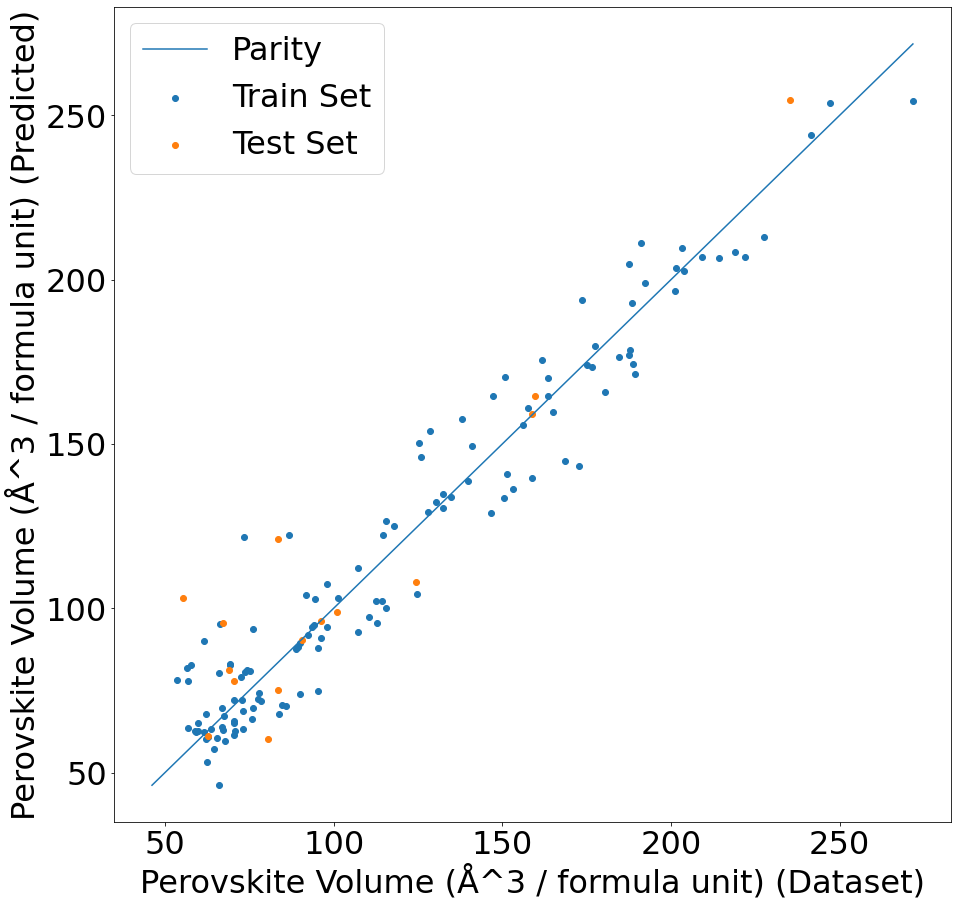

In [169]:
model_to_plot = 'r1_4term'
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = sisso_data_train['Volume'],
                                                                    train_y_pred = sisso_data_train[model_to_plot],
                                                                    test_y_true = sisso_data_test['Volume'],
                                                                    test_y_pred = sisso_data_test[model_to_plot],
                                                                    axis_label = "Perovskite Volume (Å^3 / formula unit)",
                                                                    filename = "sisso_perovskite_volume_parity.jpeg")

Finally, just so we have them, let's print out the rest of the SISSO models

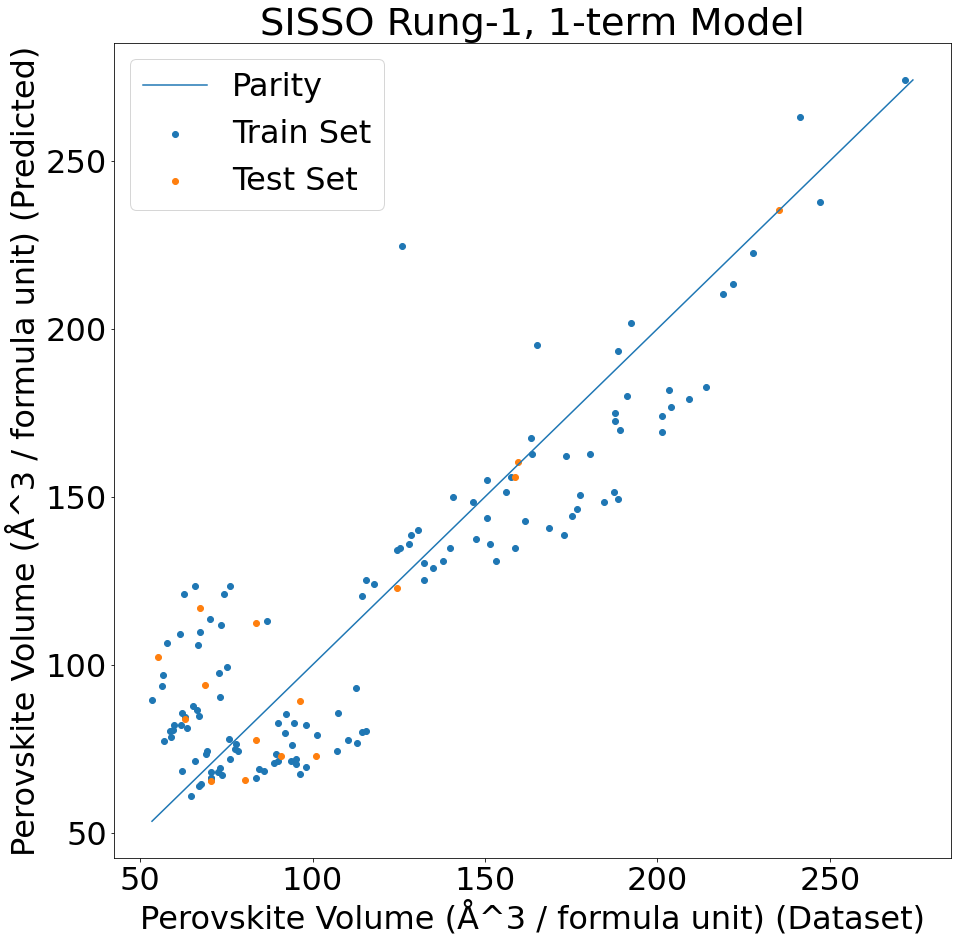

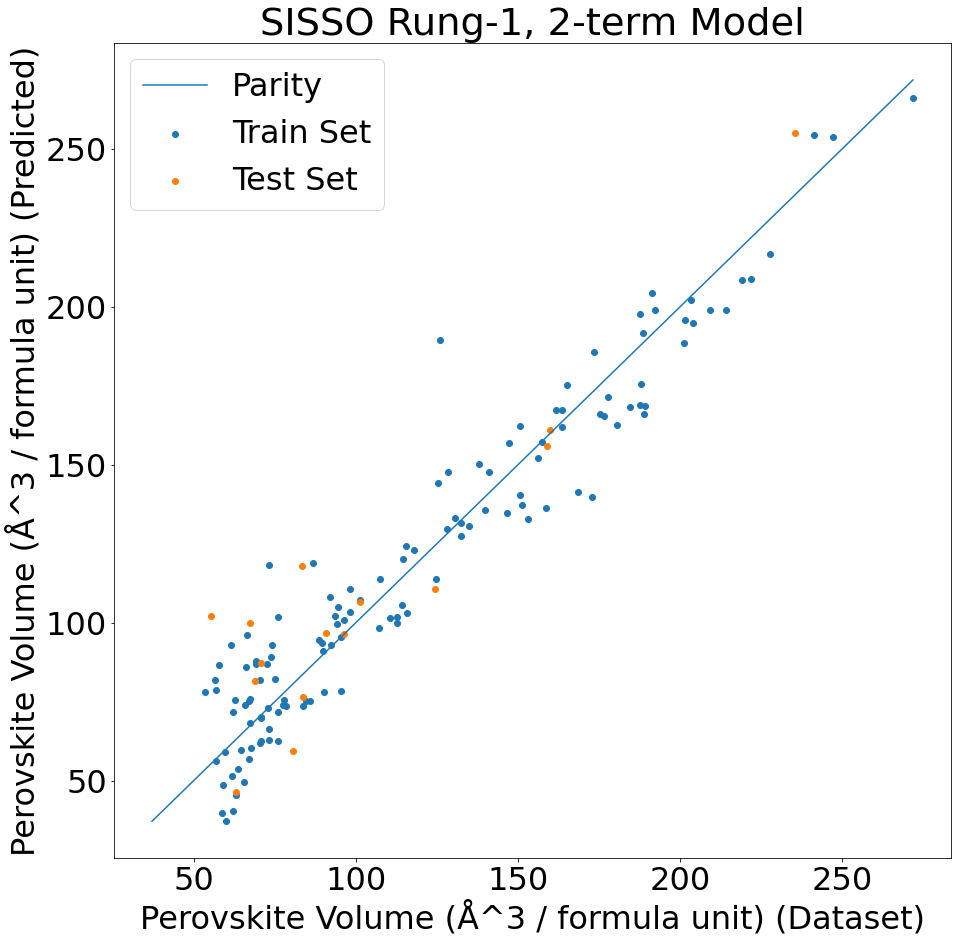

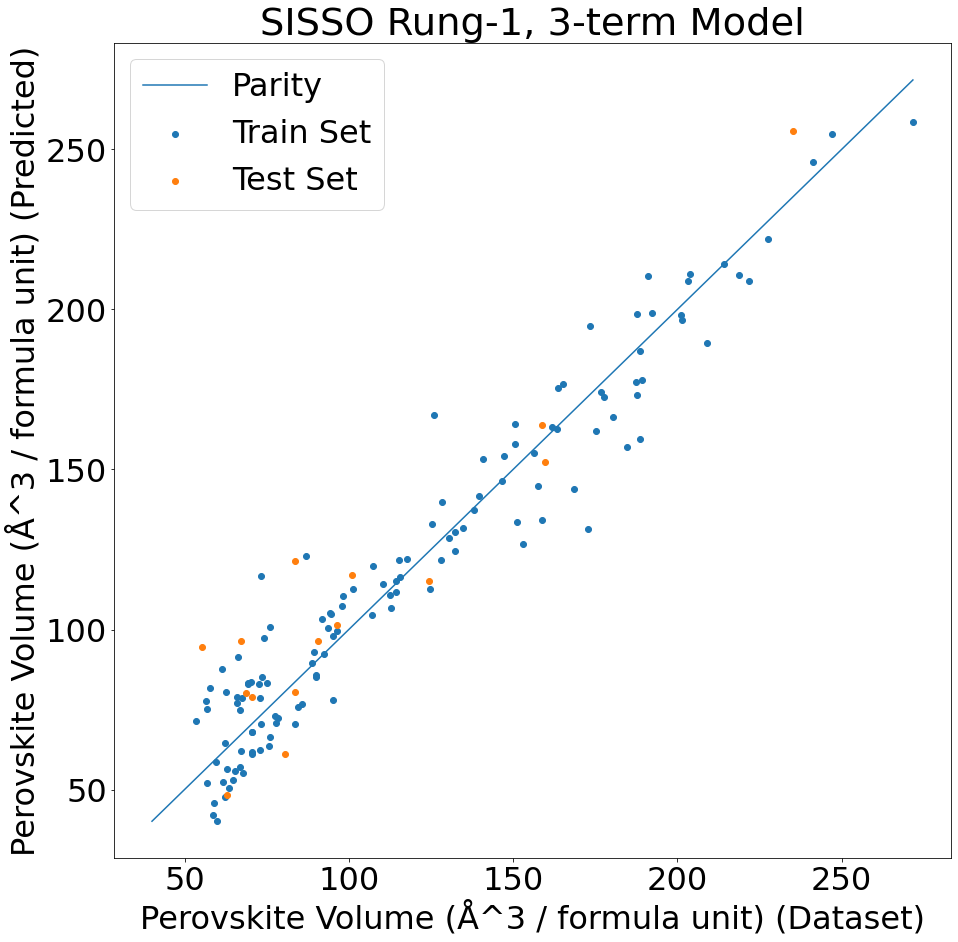

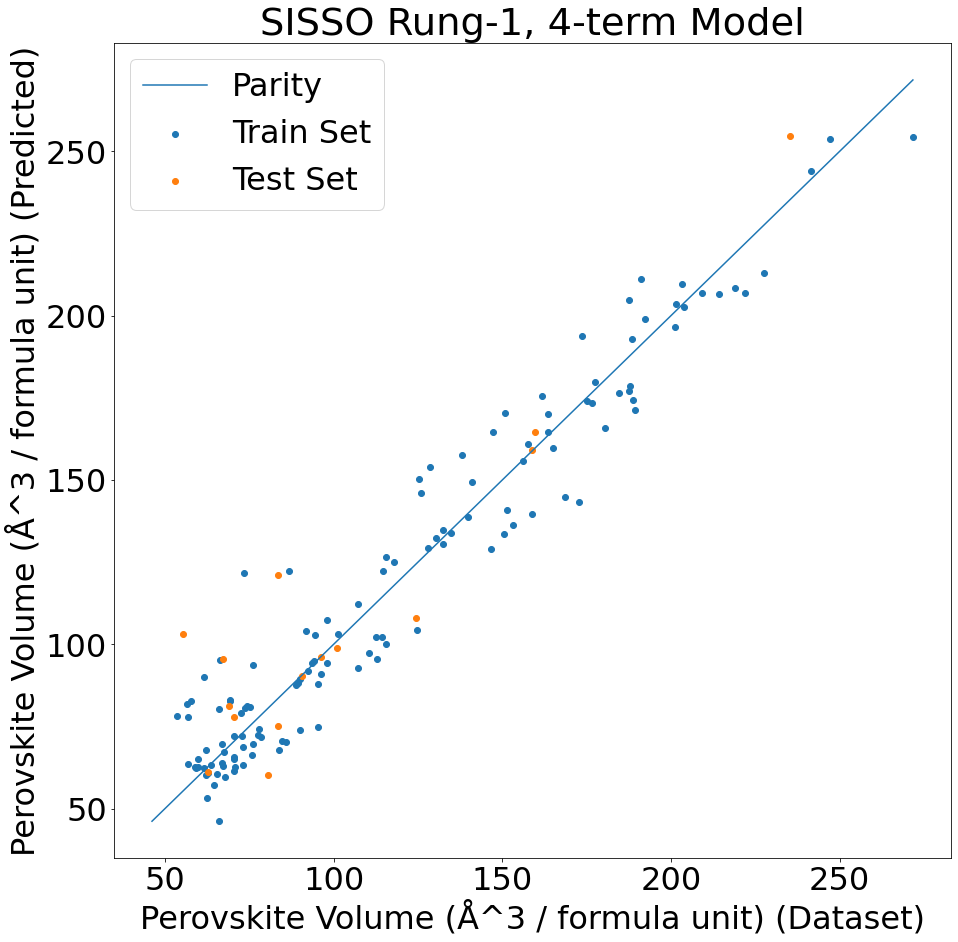

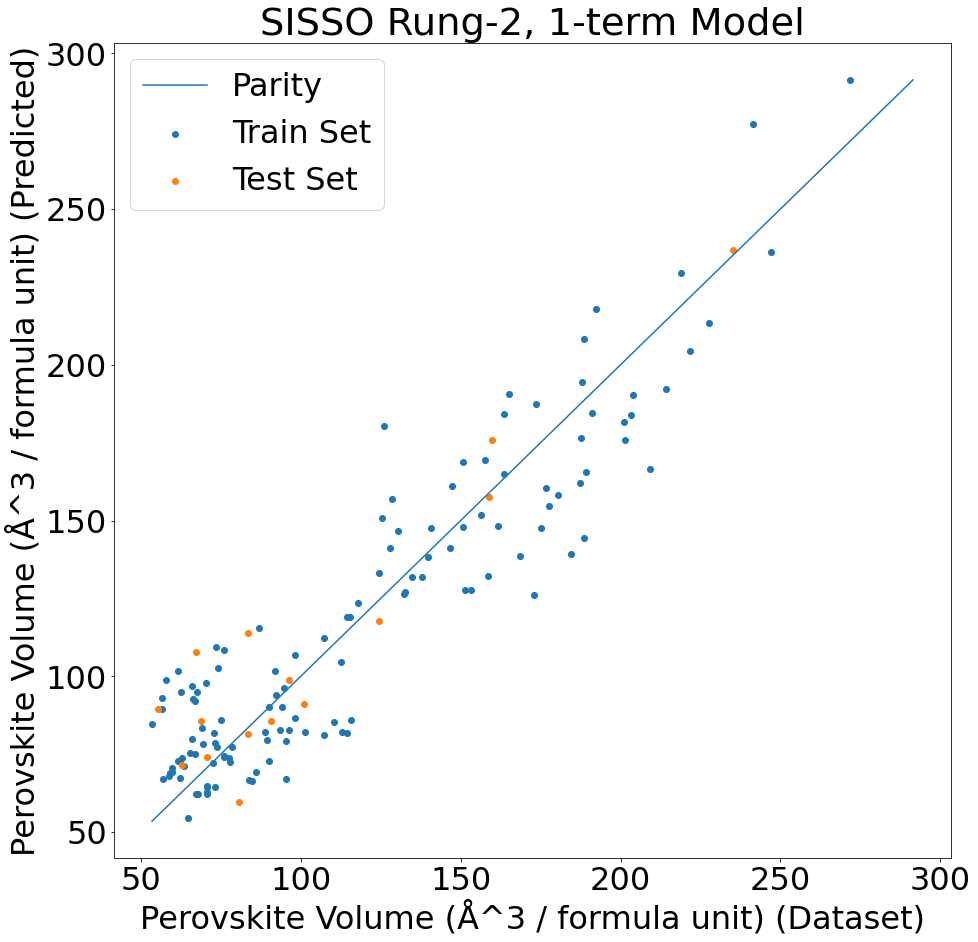

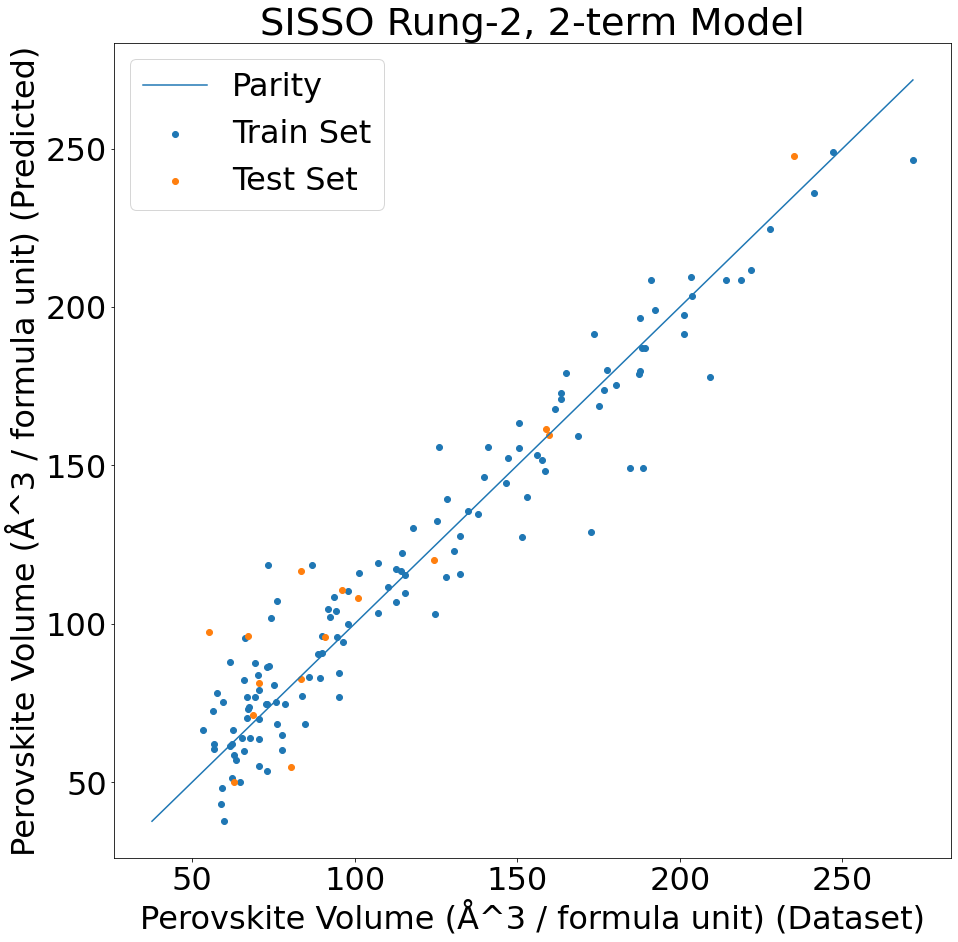

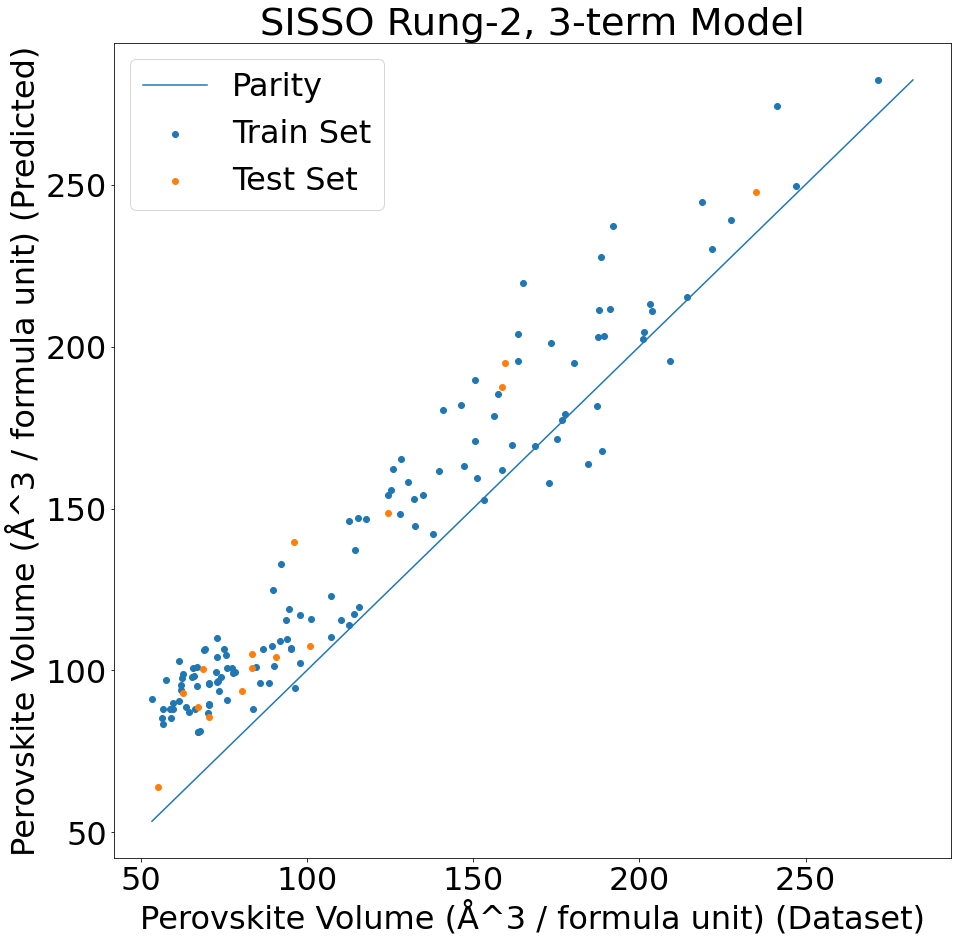

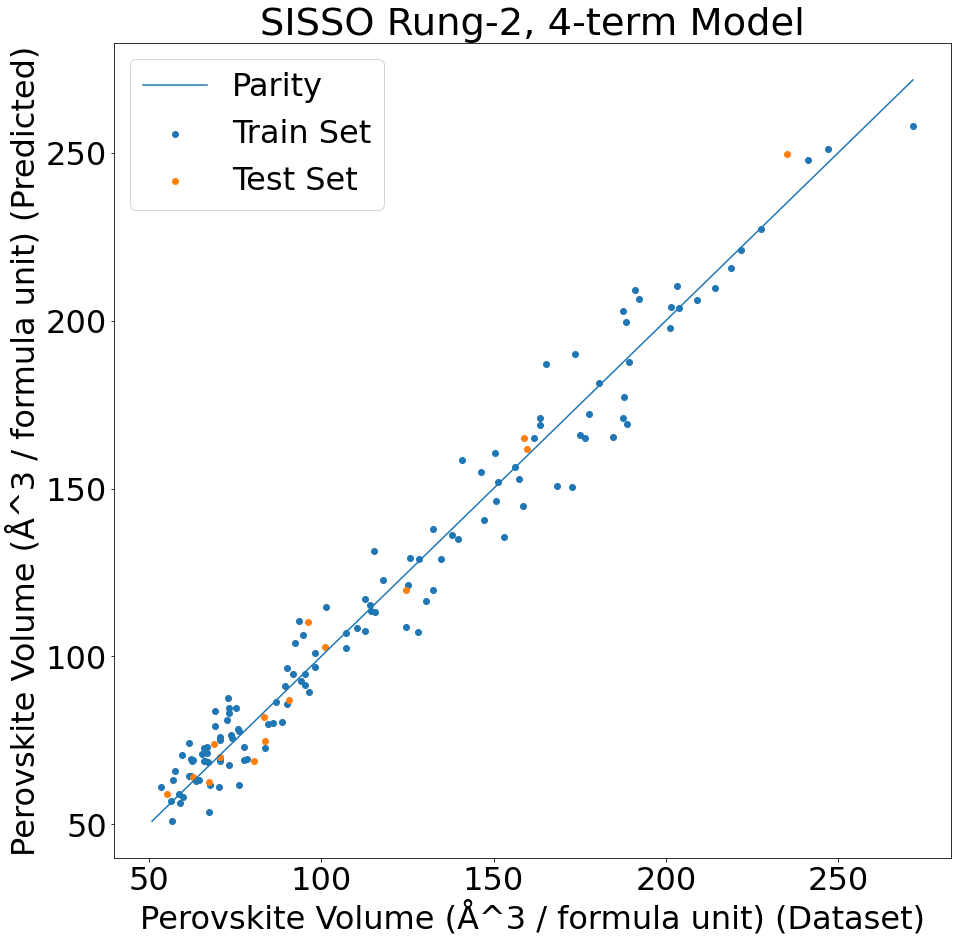

In [163]:
for model_to_plot in sisso_models.keys():
    DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = sisso_data_train['Volume'],
                                                                        train_y_pred = sisso_data_train[model_to_plot],
                                                                        test_y_true = sisso_data_test['Volume'],
                                                                        test_y_pred = sisso_data_test[model_to_plot],
                                                                        axis_label = "Perovskite Volume (Å^3 / formula unit)",
                                                                        title=f'SISSO Rung-{model_to_plot[1]}, {model_to_plot[3]}-term Model')

# Plotting parity plots

In [22]:
# Plot Configuration
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["font.size"] = 10

xgboost_pred = pd.read_csv("xgboost/xgboost_perovskite_volume_predictions.csv", index_col=0)
tpot_pred = pd.read_csv("tpot/tpot_perovskite_predictions.csv", index_col=0)

roost_train_results = pd.read_csv("roost/roost_train_predictions.csv", index_col="material_id")
roost_test_results  = pd.read_csv("roost/roost_test_predictions.csv", index_col="material_id")

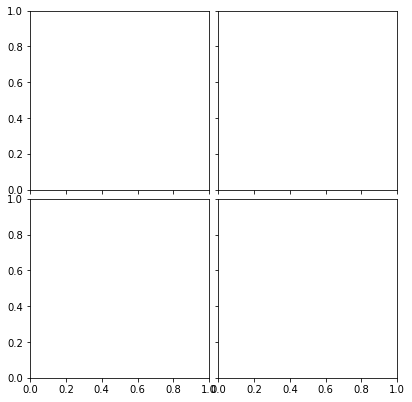

In [23]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=True,
    sharey=True,
)

fig.subplots_adjust(
    top=0.95, bottom=0.10, left=0.12, right=0.97, wspace=0.05,  hspace=0.05
)

In [24]:
def plot_parity_plot_publication_quality(
    train_y_true,
    train_y_pred,
    test_y_true,
    test_y_pred,
    axis_label,
    ax,
    filename=None,
    axis_limits=None,
    title=None,
):
    ax.clear()
    n_series = 2
    cmap = iter(plt.cm.cividis(np.linspace(0, 1, n_series)))

    train_r2 = np.round(
        sklearn.metrics.r2_score(y_true=train_y_true, y_pred=train_y_pred), 3
    )
    test_r2 = np.round(
        sklearn.metrics.r2_score(y_true=test_y_true, y_pred=test_y_pred), 3
    )

    ax.scatter(
        x=train_y_true,
        y=train_y_pred,
        label="Train R2=%.3f" % train_r2,
        color=next(cmap),
        s=15,
        marker="o",
        lw=1,
        edgecolor="black",
    )
    ax.scatter(
        x=test_y_true,
        y=test_y_pred,
        label="Test R2=%.3f" % test_r2,
        color=next(cmap),
        s=15,
        marker="s",
        lw=1,
        edgecolor="black",
    )

    if title:
        ax.title(title)
    ax.legend(frameon=False, loc="upper left", handlelength=1)


In [25]:
plot_parity_plot_publication_quality(
    train_y_true = model.prop_train,
    train_y_pred =  model.fit,
    test_y_true = test_sisso['Volume (AA^3)'],
    test_y_pred = p_est,
    ax = ax4,
    axis_label = "Perovskite Volume (Å^3 / formula unit)",
    filename = "sisso_perovskite_volume_parity.pdf",
)

In [26]:
plot_parity_plot_publication_quality(
    train_y_true = roost_train_results['volume_target'],
    train_y_pred =  roost_train_results['volume_pred_n0'],
    test_y_true = roost_test_results['volume_target'],
    test_y_pred = roost_test_results['volume_pred_n0'],
    ax=ax3,
    axis_label = "Perovskite Volume (Å^3 / formula unit)",
    filename = "sisso_perovskite_volume_parity.pdf"
)

In [27]:
topt_train_results = tpot_pred.loc[tpot_pred["TrainTest Status"] == "Training Set", ["Volume", "Prediction"]]
topt_test_results = tpot_pred.loc[tpot_pred["TrainTest Status"] == "Test Set", ["Volume", "Prediction"]]

plot_parity_plot_publication_quality(
    train_y_true = topt_train_results["Volume"],
    train_y_pred =  topt_train_results["Prediction"],
    test_y_true = topt_test_results["Volume"],
    test_y_pred = topt_test_results["Prediction"],
    ax=ax2,
    axis_label = "Perovskite Volume (Å^3 / formula unit)",
    filename = "sisso_perovskite_volume_parity.pdf",
)

In [28]:
xgboost_train_results = xgboost_pred.loc[xgboost_pred["TrainTest Status"] == "Training Set", ["Volume", "Prediction"]]
xgboost_test_results = xgboost_pred.loc[xgboost_pred["TrainTest Status"] == "Test Set", ["Volume", "Prediction"]]

plot_parity_plot_publication_quality(
    train_y_true = xgboost_train_results["Volume"],
    train_y_pred = xgboost_train_results["Prediction"],
    test_y_true = xgboost_test_results["Volume"],
    test_y_pred = xgboost_test_results["Prediction"],
    ax=ax1,
    axis_label = "Perovskite Volume (Å^3 / formula unit)",
    filename = "sisso_perovskite_volume_parity.pdf",
)

In [29]:
lims = [35, 315]
ticks = range(50, 316, 50)
mticks = range(40, 316, 10)

labels = ["XGBoost", "TPOT", "Roost", "SISSO"]
for aa, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.tick_params(direction="in", which="both", right=True, top=True)
    ax.plot(lims, lims, zorder=-1)
    ax.text(225, 50, labels[aa])

ax1.set_xlim(lims)
ax1.set_ylim(lims)

ax1.set_xticks(ticks)
ax1.set_yticks(ticks)

ax1.set_xticks(mticks, minor=True)
ax1.set_yticks(mticks, minor=True)

fig.supxlabel('Perovskite Volume (Å$^3$ / formula unit)')
fig.supylabel('Perovskite Volume (Å$^3$ / formula unit) (Prediction)')
fig.savefig("perovskite_parity.pdf")

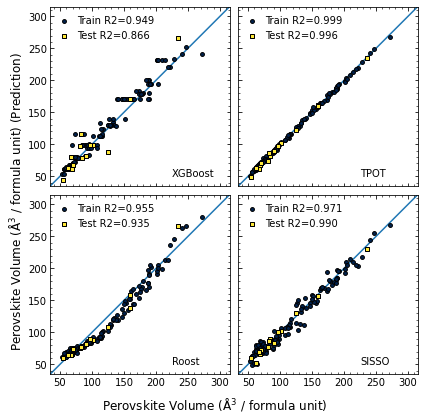

In [30]:
fig